# 6.1 Working with text data
Because deep-learning models don't take as input raw text, so we need to vectorizing text: process of transforming text into numeric tensor. 
 - segment text into words, and transform each word into a vector
 - segment text into characters, and transform each character into a vector
 - extract n-grams of words or characters, and transform each n-gram into a vector. 

All words, characters, or n-gram is called tokens, and 3 steps above is called <i>tokenization</i>. These token need more process to packed into sequence vector, to feed into Keras model.<br>
There're 2 ways for this:
 - one-hot encoding
 - token embedding (for word is word embedding).

## 6.1.1 One-hot encoding of words and characters
Each unique word or character is encoded into a 1-hot vector.<br>
Sentence of N-word is encoded into binary vector of size N (size of vocab)

In [1]:
import numpy as np

In [2]:
### WORD LEVEL ONE-HOT ENCODE
samples = ['The cat sat on the mats.', 'The dog ate my homework.']

token_index = {}
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1
            
max_length = 10

results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1

In [4]:
### using keras for word-level one-hot encode

from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

tokenizer = Tokenizer(num_words=100)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)

one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


In [5]:
word_index

{'ate': 7,
 'cat': 2,
 'dog': 6,
 'homework': 9,
 'mat': 5,
 'my': 8,
 'on': 4,
 'sat': 3,
 'the': 1}

## 6.1.2 Using word embedding
one-hot encoding are binary, sparse (many zeros), very high-dimensional (= numb words in vocab) => need another.<br>
Two ways to obtain word embeddings:
 - learn word embeddings jointly with the main task
 - load into model word embeddings that precomputed, is called <i>pretrained word embeddings</i>

## Learning word embedding with the embedding layer
The geometric relationship between word vectors should reflect the sematic relationships between words.<br>
Specifically, create embedding space with some dimension, each dimension is semantic relationships about 1 meaning.<br>
For example, from "dog" to "wolf" and "cat" to "tiger" is meaning "from pet to wild animal"<br>
<b>Remark</b>: No word-embedding space that <i>perfectly</i> map human language and used for any task.<br>

Using layer <i>Embedding</i> in keras. It's best understood as a dictionary maps integer indices (specific word) to dense vector.<br>
 - input: 2D tensor of integers with shape = (samples, sequence_length). Ex: (32, 10) meaning 32 sequences of length 10
 - output: 3D tensor of shape = (samples, sequence_length, embedding_dimentionality)

In [1]:
from keras.datasets import imdb
from keras import preprocessing

# number of words to consider as feature
max_features = 10000
# cut off the text after this maxlen
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# turn into 2D tensor of (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [2]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 155us/step - loss: 0.6759 - acc: 0.6044 - val_loss: 0.6398 - val_acc: 0.6806
Epoch 2/10
20000/20000 [==============================] - 3s 134us/step - loss: 0.5657 - acc: 0.7428 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 3s 128us/step - loss: 0.4752 - acc: 0.7808 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
20000/20000 [==============================] - 3s 130us/step - loss: 0.4263 - acc: 0.8079 - val_loss: 0.5008 - val_acc: 0.7454
Epoch 5/10
20000/20000 [==============================] - 3s 130us/step - loss: 0.3930 - acc: 0.8256 - val_loss: 0.4981 - val_acc: 0.7540
Epoch 6/10
20000/20000 [==============================] - 3s 136us/step - loss: 0.3668 - acc: 0.8395 - val_loss: 0.5013 - val_acc: 0.7534
Epo

## Using pretrained word embedding
Using precomputed embedding space known is highly structured and exhibits useful.<br>
It's like pretrained convnet.<br>
Reuse feature by pretrained word embedding when don't have many data to embedding.

## 6.1.3 Putting it all together: from raw text to word embeddings

In [4]:
import os
imdb_dir = './aclImdb/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [7]:
glove_dir = './glove.6B'

embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [10]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [11]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 1.4077 - acc: 0.5250 - val_loss: 0.7209 - val_acc: 0.5112
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6766 - acc: 0.6400 - val_loss: 0.7381 - val_acc: 0.5211
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3715 - acc: 0.8550 - val_loss: 0.7588 - val_acc: 0.5118
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3194 - acc: 0.8700 - val_loss: 0.7676 - val_acc: 0.5217
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2357 - acc: 0.9550 - val_loss: 0.7234 - val_acc: 0.5499
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1443 - acc: 0.9850 - val_loss: 1.5130 - val_acc: 0.4939
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.1664 - acc: 0.9350 - val_loss: 0.7662 - val_acc: 0.5472
Epoch 8/10
200/200 [========

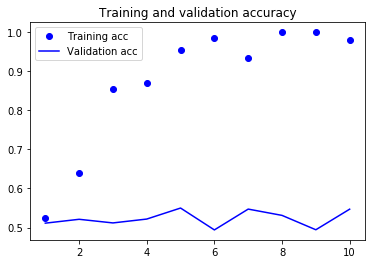

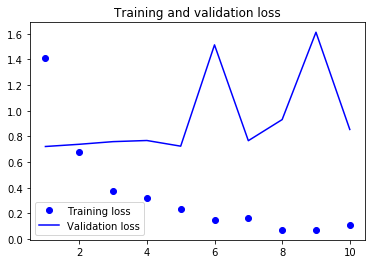

In [16]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.show()